In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt

2023-06-19 15:17:19.741343: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-19 15:17:19.743394: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-19 15:17:19.785603: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-19 15:17:19.786440: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-19 15:17:20.462732: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
(x_trainval, y_trainval), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [3]:
print(x_trainval.shape)
print(y_trainval.shape)

(50000, 32, 32, 3)
(50000, 1)


In [4]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_trainval, y_trainval, test_size=1/6, shuffle=True, stratify=y_trainval, random_state=34)
print(x_train.shape)
print(y_train.shape)

(41666, 32, 32, 3)
(41666, 1)


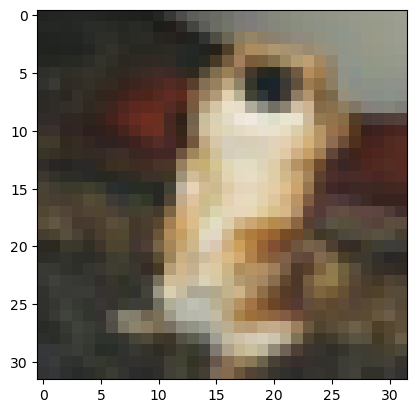

In [5]:
plt.imshow(x_train[1])

In [6]:
x_train, x_valid, x_test = x_train.astype('float32')/255, x_valid.astype('float32')/255, x_test.astype('float32')/255

In [7]:
num_feature = np.prod(x_train[0].shape)
print(num_feature)

3072


In [8]:
x_train = x_train.reshape(-1, num_feature)
x_valid = x_valid.reshape(-1, num_feature)
x_test = x_test.reshape(-1, num_feature)
print(x_train.shape, x_valid.shape, x_test.shape)

(41666, 3072) (8334, 3072) (10000, 3072)


In [9]:
def train(net, x_train, y_train, x_valid, y_valid, x_test, y_test):
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
    net.compile(loss = 'sparse_categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

    result = net.fit(x_train, y_train, epochs = 15, batch_size = 128, validation_data = (x_valid, y_valid), verbose = 0) 

    print('Test accuracy')

    test_result = net.evaluate(x_test, y_test)

    plt.plot(result.history['accuracy'])
    plt.plot(result.history['val_accuracy'])
    plt.title('ACCURACY')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.grid()
    plt.legend(['train','validation'], loc = 'best')

In [10]:
data = [x_train, y_train, x_valid, y_valid, x_test, y_test]

In [11]:
class ActivationNet(Model):
    # Set layers.
    def __init__(self, activation, num_classes=10):
        super(ActivationNet, self).__init__()
        self.fc1 = layers.Dense(64, activation=activation)
        self.fc2 = layers.Dense(128, activation=activation)
        self.out = layers.Dense(num_classes)

    # Set forward pass.
    def call(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.out(x)
        x = tf.nn.softmax(x)
        return x

2023-06-19 15:17:23.769037: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Test accuracy
313/313 [==============================] - 1s 3ms/step - loss: 2.0098 - accuracy: 0.2867


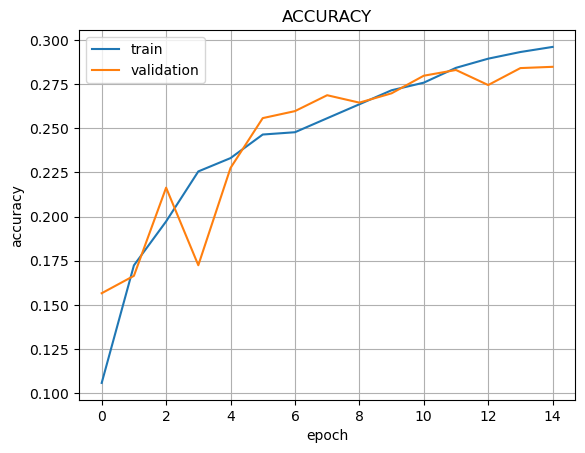

In [12]:
net = ActivationNet('sigmoid')
train(net, *data)

Test accuracy
313/313 [==============================] - 1s 3ms/step - loss: 1.5795 - accuracy: 0.4357


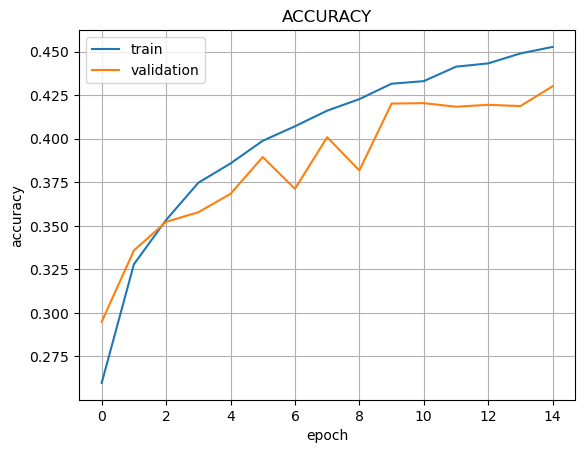

In [13]:
net = ActivationNet('relu')
train(net,*data)

In [14]:
class InitializationNet(Model):
    # Set layers.
    def __init__(self, initializer, num_classes=10):
        super(InitializationNet, self).__init__()
        self.fc1 = layers.Dense(128, activation='relu', kernel_initializer=initializer)
        self.fc2 = layers.Dense(128, activation='relu', kernel_initializer=initializer)
        self.out = layers.Dense(num_classes, kernel_initializer=initializer)

    # Set forward pass.
    def call(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.out(x)
        x = tf.nn.softmax(x)
        return x

Test accuracy
313/313 [==============================] - 1s 3ms/step - loss: 1.6126 - accuracy: 0.4271


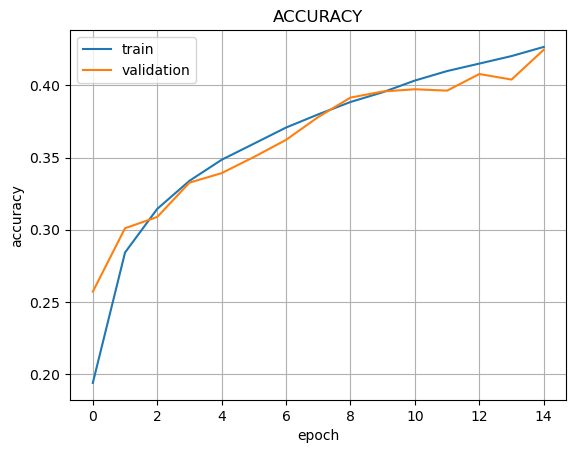

In [15]:
net = InitializationNet('normal')
train(net,*data)

Test accuracy
313/313 [==============================] - 1s 3ms/step - loss: 1.5469 - accuracy: 0.4575


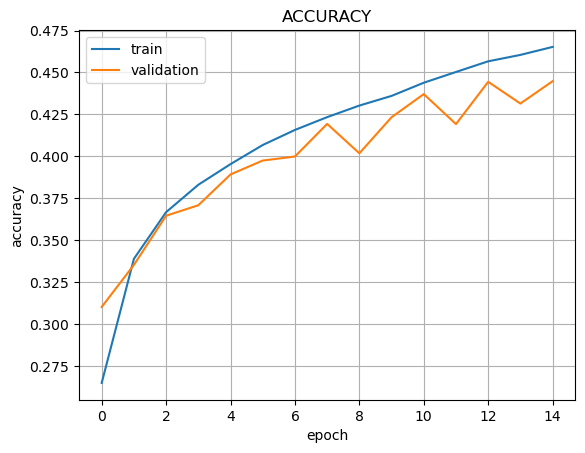

In [16]:
net = InitializationNet('glorot_normal')
train(net,*data)

In [25]:
class BNNet(Model):
    # Set layers.
    def __init__(self, num_classes=10):
        super(BNNet, self).__init__()
        self.fc1 = layers.Dense(64, activation='relu')
        self.bn1 = layers.BatchNormalization()
        self.fc2 = layers.Dense(128, activation='relu')
        self.bn2 = layers.BatchNormalization()
        self.out = layers.Dense(num_classes)

    # Set forward pass.
    def call(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.out(x)
        x = tf.nn.softmax(x)
        return x

Test accuracy
313/313 [==============================] - 1s 3ms/step - loss: 1.5338 - accuracy: 0.4662


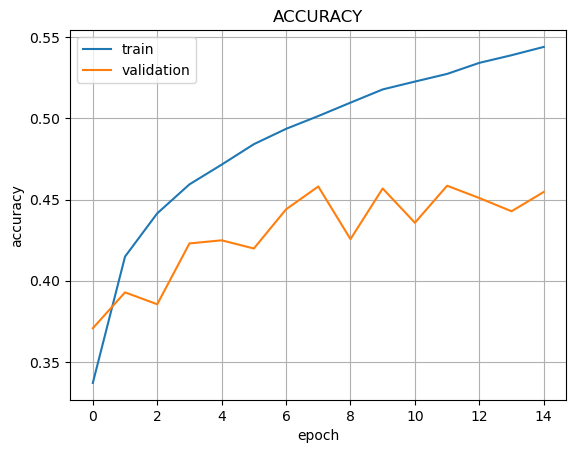

In [26]:
net = BNNet()
train(net,*data)

In [32]:
class OptimizerNet(Model):
    # Set layers.
    def __init__(self, num_classes=10):
        super(OptimizerNet, self).__init__()
        self.fc1 = layers.Dense(64, activation='relu')
        self.bn1 = layers.BatchNormalization()
        self.fc2 = layers.Dense(128, activation='relu')
        self.bn2 = layers.BatchNormalization()
        self.out = layers.Dense(num_classes)

    # Set forward pass.
    def call(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.out(x)
        x = tf.nn.softmax(x)
        return x

In [33]:
def train_momentum(net, x_train, y_train, x_valid, y_valid, x_test, y_test):
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum = 0.9)
    net.compile(loss = 'sparse_categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

    result = net.fit(x_train, y_train, epochs = 15, batch_size = 128, validation_data = (x_valid, y_valid), verbose = 0) 

    print('Test accuracy')

    test_result = net.evaluate(x_test, y_test)

    plt.plot(result.history['accuracy'])
    plt.plot(result.history['val_accuracy'])
    plt.title('ACCURACY')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.grid()
    plt.legend(['train','validation'], loc = 'best')

Test accuracy
313/313 [==============================] - 1s 3ms/step - loss: 1.6051 - accuracy: 0.4607


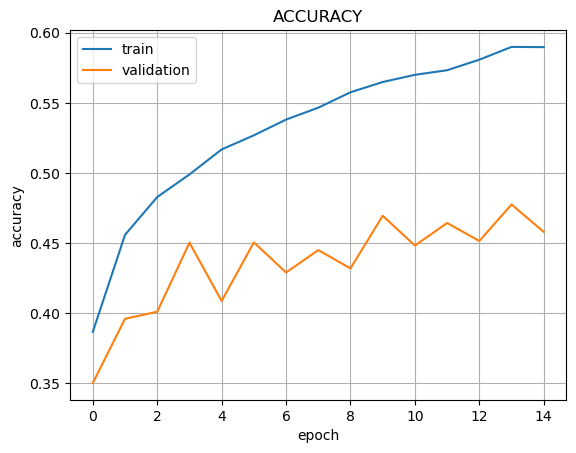

In [34]:
net = OptimizerNet()
train_momentum(net, *data)

In [35]:
def train_Adam(net, x_train, y_train, x_valid, y_valid, x_test, y_test):
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    net.compile(loss = 'sparse_categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

    result = net.fit(x_train, y_train, epochs = 15, batch_size = 128, validation_data = (x_valid, y_valid), verbose = 0)

    print('Test accuracy')

    test_result = net.evaluate(x_test, y_test)

    plt.plot(result.history['accuracy'])
    plt.plot(result.history['val_accuracy'])
    plt.title('ACCURACY')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.grid()
    plt.legend(['train','validation'], loc = 'best')

Test accuracy
313/313 [==============================] - 1s 3ms/step - loss: 1.4794 - accuracy: 0.4906


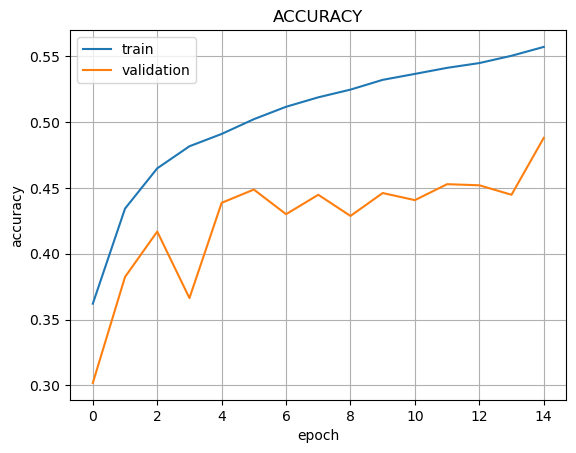

In [36]:
net = OptimizerNet()
train_Adam(net, *data)